In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT base uncased model
# https://huggingface.co/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def show_predictions(predictions):
    percentage_0 = (np.count_nonzero(predictions == 0) / len(predictions)) * 100
    percentage_1 = (np.count_nonzero(predictions == 1) / len(predictions)) * 100

    labels = ["0", "1"]
    percentages = [percentage_0, percentage_1]

    plt.bar(labels, percentages, color=["red", "blue"])
    plt.xlabel("Predictions")
    plt.ylabel("Percentage")

    plt.show()

In [3]:
def eval(model, texts):
    model.eval()

    inputs = tokenizer(
        [text for text in texts],
        return_tensors="pt",
        truncation=True,
        padding=True,
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int).flatten()

    return predicted_labels

In [4]:
import torch


try:
    model.load_state_dict(torch.load("bill_hardy.pt"))
except:
    print(
        "Model not found; please train it using `2_BERT_binary_classification_bill.ipynb`"
    )
    raise

Generate datasets:
* Corpus 1: texts from narrators other than Bill Hardy and converted into the present tense
* Corpus 2: texts from Bill Hardy and converted into the past sense

In [5]:
# the first corpus contains texts belonging to narrators other than Bill Hardy and
# that have been transformed to use the present tense instead of the past tense
corpus_1 = [
    "I plunge for the last time. The few remaining figures and letters swim as they come up to me. Then I take them in. There are no more. I glance about me. I feel I am getting my money’s worth. London is like that; it accepts the wanderer home with a sort of warm indifference. The woman’s beauty is, I surmise, profound; her creamy dress, contrasting with her vivid colouring, shows to me, though more as white against a gay brick sepulchre than snow against roses. Yes it is a dreadful beauty, as far as I can see, and I recall the stark phrases: Which swept an hundred thousand souls away; yet I alive. But he was not; the writer had strangely died today. And again they continued this wretched course three or four days: but they were every one of them carried into the great pit before it was quite filled up. Where is Henry? Ah, he is standing by her, close enough to touch the small buoyant face that topped her pillared neck most like a bell-flower on its bed. Would he appreciate?",
    "Of course I am sorry to say good-bye to old Medehamstede; but it is pleasant to sit down and to really find myself alone at last. Those emotional times were trying to us all. I feel that my lips are paler than I like; but a touch of Pasquier’s claret soon puts me right. Dear old Pasquier, I have come across him in Paris, at that little place in the Rue de la Harpe, a street in which, I have been told, there was a touch of orderly room even in the disorderly houses. I open a magazine and look hastily through the last paragraphs of the short stories. I am all for love; but fading out on an embrace never appealed to me. The embrace in my short stories—and my life is all short stories, I have come to think—occurs in the first few words. And afterwards the plot. The complete novel length looks better. It is called Savage Conqueror, and I like that.",
    "I find myself by that one of the windows which overlooks the stone broach spire—a rarity in Kent—of Pluckley church, and the light would strike my book from over my right shoulder. I draw a volume from my pocket; blind-tooled on the green in a double circle was a single star above what was perhaps a sea. I have little experience of it up to the present; I have only been married once. That was due to a misunderstanding between myself and a young person, and I wonder if such a reason for marriage would ever come my way. I have never been married, and hardly felt like beginning now. It is the tenth edition, of 1917. No, Sir; it is not an interesting subject. Not a woman has entered yet. I am in for a ticklish business, and I know it. Forging ahead, I suppose they would call it, since the woman is not yet dead. You might not hear of her again.",
    "I feel as good as a man can on this day. Everything horticultural, in the awful and literal sense of the word, is lovely. Green blood, as I considered before breakfast, I am glad to conserve. I receive a letter from Miss Doncaster over the crumbs of toast and the last clear smear of marmalade, telling me that the old man will be coming today, on her advice to take mine. I confess that she is stirring me strangely. I light a Nestor and consider her letter once more. To pestle a poisoned poison behind his crimson lights. That is a nice thing to ask of a comparative stranger. It will have to be scanned. Poor old man; but everyone must bump up against his Waterloo, and today is the day of the meeting at La Belle Alliance. It is not appropriate.",
    "It is just when the girl from the Asolo silk mills contends that morning is. There is something, I reflect, about the fashion, beastly, in the awful and literal sense of the word, as of equals, in which youth treats the young day. Heaven knows I would have been in bed had not my head been surcharged with too perilous a stuff for sleep. I spend those six hours in an agony of recapitulation. Even as a tiny toddler, at old Mrs. Larkin’s school, when I was technically a mixed infant, I showed signs of possessing these uncanny powers. In fact Mrs. Larkin might have called me Clare, so both voyant and audient am I. For a long time I sit and muse, looking into vacancy across the table. Gradually a realisation comes to me that I would revisualise more connectedly on an assuaged stomach. I hope for breakfast soon, nor am I to be disappointed. There is that silly girl of mine bursting into pang in the sausage, just like Pippa as she always does.",
    "At my meeting with Clement yesterday, he had been quite specific: less than twenty thousand yards as average—seventeen thousand six hundred to be exact—full ration of the assassin’s wonderful substance, a little act of justice at the end of less than a week, and then the glorious stuff galore for ever. I feel excellent as I take my second pill. At least I am on my way, for I come upon the major half of a publishing firm; they have always been very good to me, what with Austin Freeman, Oppenheim and Mary Roberts Rinehart. O my mother is loath to have her go away, all the week she think of her, she watch for her many a month. And then there is a forgotten line. But the red squaw never come nor is heard of there again. I think it a pity that Hodder is not there: what a sweet name for a village! My signs are a rain-proof coat, good shoes. No friend of mine takes his ease in my chair. I have no chair.",
    "He always talks to me about murder, when we are alone together. And to-day he tells me it is the birthday of a good one in prison. John and Cornelius, the Dort people; I can’t say I understood very much. But I like his name, and shows him so, for he has always been very clement to me, even about that cat Jasmine. By the bye, Tusitala and Flora have both come over to our place. Of course you might say that is nothing to make a song about. But others had not agreed. And just as I am feeling how much I love him, he puts on funny clothes and goes away. I lower myself and make love to Flora. It is quite late when he comes back with her. He has always told me that I am absurdly sensitive. It might be so. Explain it how you will, when I first set eyes on her I fekt no vibration, no hint at all, of my latter end. I am banished and sleep miserably with Flora.",
]

In [6]:
predicted_labels = eval(model, corpus_1)
print(predicted_labels)

[1 1 1 1 1 1 1]


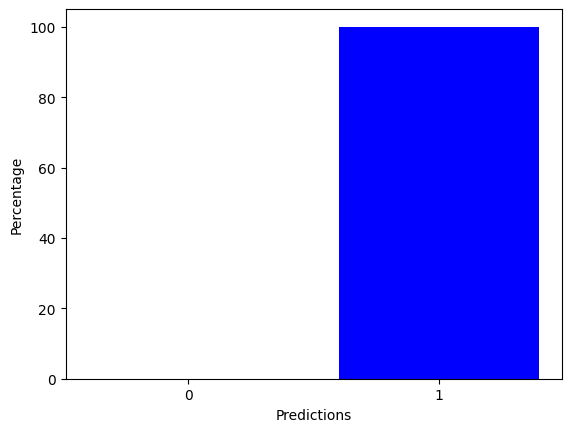

In [7]:
show_predictions(predicted_labels)

In [8]:
# the second corpus contains texts belonging to Bill Hardy and that have been
# transformed to use the past tense instead of the present tense
corpus_2 = [
    "I sat down alone at the appointed table and took up my pen to give all whom it may concern an exact account of what may have happened. Call me nervous, call me fey, if you will; at least this little pen, this mottled black and silver Aquarius, with its nib specially tempered to my order in Amsterdam, was greedy. It has not had much work since it flew so nimbly for the dead old man. As I watched the sea, Casy Ferris passed with down-dropped eyes. Of course, this day was the day. Her father reminded me of a valetudinarian walrus. But she had, I supposed, to have somebody. St. Lazarus-in-the-Chine was full, already, no doubt. I thought she was rash; but it was none of my business. Where about the graves of the martyrs the whaups were crying, my heart remembered how. Strange that he came into my head so much to-day. I hope it’s over some flotsam fish that the birds are making whaupee. But all the nice gulls love a sailor. Ugh.",
    "I thought I would try a cup of what they insolently called Golden Tips, a find young Tippy Tea. And then they said specifically No Tips. It was very disheartening. While I was waiting for it, and for the possible her, I studied the only literature before me. What is a Loganberry Kiss? Is it at all like the Plover’s Lunch, that hurts and is desired? It was strange to think that Catharine was even at this moment turning a Somerset in front of the altar. The whole business reminded me of the time we lay outside Jifjaffa, and the Padre said to me: “I would rather have written that poem than take castor oil in the morning.” I had been reading him my Ode on the Intimations of Immorality in Early Childhood. Well, well. How vividly, whenever I adventure on stew now, I remember the stew we had that night. How it all comes back. The whole circumstances of this meeting were so mysterious. It gars me grue, if I may be permitted the expression.",
    "I was conveniently situated, with the Moon on the one hand and the Dawn on the other. Conveniently situated for some things, that is. Here was young Sawnie, for instance, parking his Fordor with a perfectly grey face. I was sorry. He was fumbling with the lock arrangement. I’ve never tried the stuff myself; bad for the hand. He was visiting the Moon for the first time to-day and just the first. I almost wished I had tried the Lapsang. I remember I once received seven pounds of Lapsang from Grace. Or the Moning, very choice, delicate flavour. Why go to pubs? There would be no Moning at the bar. Yes, there’s Kate Somerset, looking actually proud. And that must be he. Poor child. Ah, here she was. She slipped like a blonde lily into the chair opposite. My heart turned over a little in my breast and then re-settled. She was very beautiful. Why should I think her beauty somewhat sinister? Because, perhaps, marriage was in the air?",
    "I hated seeing things like this in the paper. Bill to Solve the Traffic Problem. Bill to improve the Secondary Schools. I was never asked. I was not qualified. It was all so sudden. I found it hard to reconcile my guest with the Duchess of that name, though I knew how popular everything to do with the Wimpole Street singer was just then, except perhaps her singing. Toll slowly, a match box rhythm. Bryant and, of course, May. Rub gently, she was here, under the snow. Poor Oscar. Nor will the ends drop off. Nor can her eyes go out. Pure Francis Thompson. He sold matches. But I felt I was letting the dear girl down. There was a contrast: Fidelia Faustina Flora Blackwood, sister of Ebenezer Blackwood, which of course it is. She marched by on muscular pink hocks. The thought of that evening in the Left Luggage Office parched me, made my heart beat differently. I must say I envied Alexander having his first, and perhaps his second, in there. I thought wistfully of the poet’s lines: But rum alone’s the tipple, and the heart’s delight",
    "Of the old bold mate of Henry Morgan. My guest had, I thought, a Byzantine beauty, as of a golden snake. Was she, or was she not, a little pale about the Gills? Sanders came into view again, seemingly improved by his lunar visit. He propped himself and gazed out to the northwest over the water of the little bay, drinking it all in. I followed his gaze and saw, as Henry saw when he was at home in Woodstock, twisted trees in front of the thick-windowed little house, and a foreground of exquisitely coloured vegetation with somewhat the consistency of fur stoles: a breast of the hills under a long cloud. I had given her nothing at all. She had let me see the original of the dead man’s letter. It was funny, it was rather fearful, to feel a wet skeleton hand putting hers into mine. Why, I wondered? Not that it could really be skeleton yet; it must be—worse: a loathsome mass of detestable putrescence.",
    "This was good. She accepted Lover’s Delight from me. She had spoken very little; but she urged me to make trial of a Banana Split. Was there some esoteric meaning behind the titles? Then Ecky passed over to the Dawn. Alexander’s my name. They ca’d me Ecky when I was a boy. Eh, Ecky! Ye’re a awfu’ old man. Emotional stuff. Anyway Ecky had disappeared in the Dawn. I almost wished I took it. The hard stuff, I meant; but it would have ruined my hand. Where would my income be if Aquarius were to turn Gemini? She told me a lot, each word huskily lisping over that round petulant vermilion lower lip, of a doctor friend of hers. I had only known her a few minutes; but I hated to think she would change—her voice hit a pocket, just like a plane, when she talked of him—an honest station between King’s Cross and Edinburgh for—what was it?—being’s drone pipe, whose nostril turns to blight the shrivelled stars and thicks the lusty breathing of the sun.",
    "I wished she would tell me more. I wished she would give me some hint as to why the deceased wished us to know each other. Sitting here, stung by those wild gold waspish eyes, I wondered terribly. I wondered dreadfully. I did think it was a pity. Auroral imbibitions had set Alistair on young uncertain feet once more, and he had handsomely taken the Dagenham bus en route for the converted oast-house where his mother lived. I hoped it would not backslide. Barbara passed from right to left, dear child. Her one-piece was yellow jasmine, and she spurned the concrete and especially the abstract with those bronze legs of hers. The tawny curls of her are springed to catch woodcocks, and more than woodcocks. She waved a towel capriciously, take it or leave it, at me. What would I do then, if the other leaned across and said what the blind sailor said? But wiseacres contend that it was Kismet. Off went his arm to-day. Yes, what would I feel like? She was delightful.",
]

In [9]:
predicted_labels = eval(model, corpus_2)
print(predicted_labels)

[0 0 0 0 0 0 0]


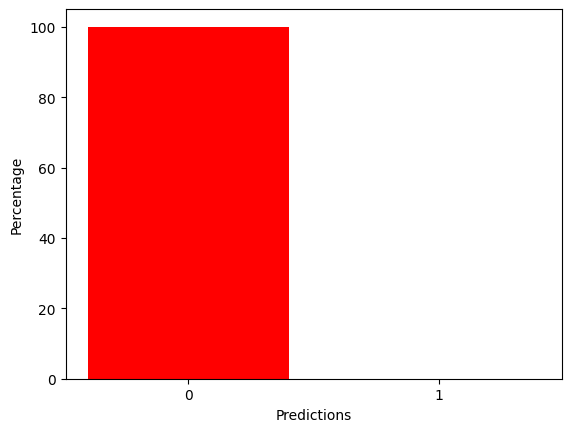

In [10]:
show_predictions(predicted_labels)